In [1]:
import numpy as np
import numpy.random as npr
import json
import io
import time
import os.path
import six
import copy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()
plt.rcParams['figure.figsize'] = (6,4)

import chainer as ch
import chainer.training.extensions # for some reason this isn't automatically imported

In [2]:
# allow for importing local infonet package
import sys
import os
sys.path.append(os.path.abspath('..'))
# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

In [21]:
from infonet.vocab import Vocab
from infonet.preprocess import compute_flat_mention_labels, Entity_BIO_map, BIO_map, typed_BIO_map
from infonet.util import convert_sequences, SequenceIterator
from infonet.tagger import extract_mentions, extract_all_mentions

ImportError: cannot import name compute_tag_map

# Loading data

In [4]:
data = json.loads(io.open('../data/ace_05_head_yaat.json', 'r').read())

In [23]:
# get vocabs
token_vocab = Vocab(min_count=2)
for doc in data.values():
    token_vocab.add(doc['tokens'])

boundary_vocab = Vocab(min_count=0)
for doc in data.values():
    doc['boundary_labels'] = compute_flat_mention_labels(doc, typed_BIO_map)
    boundary_vocab.add(doc['boundary_labels'])
    
def compute_tag_map(boundary_vocab):
    """ Automatically computes the data needed for decoding mentions
    from tags, given the tagset we are using
    """
    tag_map = {
        'start_tags':tuple([ t for t in boundary_vocab.vocabset
                             if t.startswith(('B', 'U'))]),
        'in_tags':tuple([ t for t in boundary_vocab.vocabset
                             if t.startswith(('B', 'U', 'I', 'L'))]),
        'out_tags':tuple([ t for t in boundary_vocab.vocabset
                             if t.startswith('O')]),
        'type_map':{t:t.split('-')[1]
                    if len(t.split('-')) > 1
                    else None
                    for t in boundary_vocab.vocabset
                    }
    }
    return tag_map
tag_map = compute_tag_map(boundary_vocab)

In [6]:
def print_doc_with_spans(doc):
    doc_str = ''
    nodes = [ ann for ann in doc['annotations'] if ann['ann-type']=='node']
    ann_starts = set([s['ann-span'][0] for s in nodes])
    ann_ends = set([s['ann-span'][1] for s in nodes])
    ann_types = {s['ann-span'][1]:s['type'] for s in nodes}
    for i, token in enumerate(doc['tokens']):
        if i in ann_starts:
            doc_str += '['
        doc_str += token
        if i+1 in ann_ends:
            doc_str += ']'
            doc_str += '({}:{})'.format(ann_types[i+1], i+1)
        doc_str += ' '
    print doc_str

In [319]:
# # all mapping schemes assume the annotation spans correspond with python indexing
# # eg ann-span = [0,2] means the interval [0,2) or tokens[0:2]

# def Entity_BIO_map(mention_labels, annotation):
#     """ Uses BIO scheme (untyped) for entities only """
#     if annotation['node-type'] == 'entity':
#         left, right = tuple(annotation['ann-span'])
#         mention_labels[left] = 'B'
#         for i in range(1, right-left):
#             mention_labels[left+i] = 'I'
#     return mention_labels

# def Entity_typed_BIO_map(mention_labels, annotation):
#     """ Uses BIO scheme (typed) for entities only """
#     if annotation['node-type'] == 'entity':
#         mention_type = annotation['type']
#         left, right = tuple(annotation['ann-span'])
#         mention_labels[left] = 'B-'+mention_type
#         for i in range(1, right-left):
#             mention_labels[left+i] = 'I-'+mention_type
#     return mention_labels

# def Entity_BILOU_map(mention_labels, annotation):
#     """ Uses BILOU scheme (untyped) for entities only """
#     if annotation['node-type'] == 'entity':
#         left, right = tuple(annotation['ann-span'])
#         if left == (right-1):
#             mention_labels[left] = 'U'
#         else:
#             mention_labels[left] = 'B'
#             for i in range(1, right-left-1):
#                 mention_labels[left+i] = 'I'
#             mention_labels[right-1] = 'L'
#     return mention_labels

# def Entity_typed_BILOU_map(mention_labels, annotation):
#     """ Uses BILOU scheme (typed) for entities only """
#     if annotation['node-type'] == 'entity':
#         mention_type = annotation['type']
#         left, right = tuple(annotation['ann-span'])
#         if left == (right-1):
#             mention_labels[left] = 'U-'+mention_type
#         else:
#             mention_labels[left] = 'B-'+mention_type
#             for i in range(1, right-left-1):
#                 mention_labels[left+i] = 'I-'+mention_type
#             mention_labels[right-1] = 'L-'+mention_type
#     return mention_labels

# def compute_flat_mention_labels(doc, scheme_func=Entity_BIO_map):
#     """ Takes a YAAT style document and computes token-level mention label list.

#     This function only considers the outermost spans (as per ACE evaluation)
#     by editing the mentions of shortest span-length to longest.
#     Thus wider mentions will override narrower nested mentions.

#     Example:
#     --------

#     tokens: ['part', 'of' , 'mention', '.', 'not', 'part']
#     with annotation: {'ann-type':'node',
#                       'node-type':'entity',
#                       'ann-span':[0,2]}
#     with scheme: BIO

#     yields:
#     mention_labels = ['B', 'I', 'I', 'O', 'O', 'O']
#     """
#     mention_labels = ['O' for token in doc['tokens']]
#     mentions = [ annotation for annotation in doc['annotations'] if annotation['ann-type'] == 'node' ]
#     # create annotations from shortest to longest, so that largest spans overwrite smaller
#     annotations = sorted(mentions, key=lambda x:x['ann-span'][1]-x['ann-span'][0])
#     # make sure there are no overlapping mentions
#     def is_bad_overlap(x,y):
#         # can't bad overlap if either boundaries are same
#         # case: [ )   or  [ )
#         #       [  )     [  )
#         if (x[0] == y[0]) or (x[1] == y[1]):
#             return False
#         # only check from left to right
#         l, r = (x,y) if x[0] < y[0] else (y,x)
#         # case [  )    (what we're looking for)
#         #        [  )
#         if l[1] > r[0] and l[1] < r[1]:
#             return True
#         # case [   )  (true nesting is ok)
#         #        [)
#         else:
#             return False

#     bad = False
#     for i, a in enumerate(annotations):
#         for b in annotations[i+1:]:
#             if is_bad_overlap(a['ann-span'], b['ann-span']):
#                 bad = True
#                 print "Bad overlap", (a['ann-span'],b['ann-span'])
#     # assert not any([ is_bad_overlap(a['ann-span'], b['ann-span'])
#     #                  for i, a in enumerate(annotations)
#     #                  for b in annotations[i+1:] ])

#     for annotation in annotations:
#         mention_labels = scheme_func(mention_labels, annotation)
#     return bad#mention_labels


In [320]:
# for i, doc in enumerate(data.values()):
#     if compute_flat_mention_labels(doc):
#         print i, '-'*80
# #         print '.'*(50)
#         print_doc_with_spans(doc)
# #         break

In [12]:
from scipy.misc import comb
comb(4,2)

6.0

In [17]:
(1,2)+(3,4)

(1, 2, 3, 4)

In [56]:
def resolve_annotations(annotations):
    """ Remove any duplicate, nested, or overlapping mentions and their relations."""
    def overlaps(node, qnode):
        nspan = node['ann-span']
        qspan = qnode['ann-span']
        if nspan[0] == qspan[0] or nspan[1] == qspan[1]: # sharing a boundary => overlap
            return True
        elif nspan[0] > qspan[0] and nspan[0] < qspan[1]: # [  (  ]
            return True
        elif (nspan[1]-1) > qspan[0] and nspan[1] < qspan[1]: # [  )  ] 
            return True
        else:
            return False
        
    # sort all of the mentions by width
    # and resolve them by preference to width
    # so if we find a mention that is within or overlaps 
    # a mention we've previously seen, omit it
    sorted_nodes = sorted([ a for a in annotations 
                           if a['ann-type'] ==u'node'],
                           key=lambda x: x['ann-span'][1] - x['ann-span'][0],
                           reverse=True)
    resolved_annotations = []
    for node in sorted_nodes:
        for qnode in resolved_annotations:
            if not overlaps(node, qnode):
                resolved_annotations.append(node)
                
    # now only include relations whose constiuent mentions are still around
    node_id_set = set([node['ann-uid'] for node in resolved_annotations ])
    for ann in annotations:
        if ann['ann-type'] == u'edge':
            if ann['ann-left'] in node_id_set and ann['ann-right'] in node_id_set:
                resolved_annotations.append(ann)
    return resolved_annotations

def compute_mentions(doc, fine_grained=False):
    """ Compute gold mentions as (*span, type) from yaat.

    Return them sorted lexicographicaly. 
    This is necessary because relations are calculated by forward choosing
    which requires that the mentions be ordered so no relations are omitted."""
    mentions = []
    for ann in doc['annotations']:
        if ann['ann-type'] == u'node':
            mention_type = ann['node-type']+':'+ann['type']
            if fine_grained:
                mention_type += ':'+ann['subtype']
            mentions.append((ann['ann-span'][0], ann['ann-span'][1], mention_type))
    return sorted(mentions, key=lambda x: x[:2])

def compute_relations(doc, fine_grained=False):
    relations = []
    id2ann = { ann['ann-uid']:ann for ann in doc['annotations']}
    for ann in doc['annotations']:
        if ann['ann-type'] == u'edge':
            left_span = id2ann[ann['ann-left']]['ann-span']
            right_span = id2ann[ann['ann-right']]['ann-span']
            rel_type = ann['edge-type']+':'+ann['type']
            if fine_grained:
                rel_type += ':'+ann['subtype']
            relations.append((left_span[0], left_span[1], right_span[0], right_span[1], rel_type))
    return relations

# get vocabs
token_vocab = Vocab(min_count=2)
for doc in data.values():
    token_vocab.add(doc['tokens'])

boundary_vocab = Vocab(min_count=0)
mention_vocab = Vocab(min_count=0)
relation_vocab = Vocab(min_count=0)
for doc in data.values():
    doc['annotations'] = resolve_annotations(doc['annotations'])
    
    # boundary labels
    doc['boundary_labels'] = compute_flat_mention_labels(doc, typed_BIO_map)
    boundary_vocab.add(doc['boundary_labels'])
    
    # mention labels
    doc['mentions'] = compute_mentions(doc)
    mention_vocab.add([m[2] for m in doc['mentions']])
    
    # relation labels
    relations = compute_relations(doc)
    # add in NULL relations for all mention pairs that don't have a relation
    rel_mentions = set([ r[:4] for r in relations])
    seen_mentions = set()
    n_null, n_real = 0, 0
    for i, m1 in enumerate(mentions):
        for m2 in mentions[i+1:]:
            r = m1[:2] + m2[:2]
            if r not in rel_mentions:
                relations.append(r+(u'--NULL--',))
                n_null += 1
            else:
                n_real += 1
                seen_mentions |= set([r])
    assert n_real+n_null == int(comb(len(mentions), 2)), "There should always be m choose 2 relations"
    doc['relations'] = relations
    relation_vocab.add([r[4] for r in doc['relations']]) 
    
# mention_vocab = Vocab(min_count=0)
# relation_vocab = Vocab(min_count=0)
# for i, doc in enumerate(data.values()[:]):
#     s = ''
#     s += '{}:: '.format(i)
# #     for t, b in zip(doc['tokens'], doc['boundary_labels']):
# #         print t,b
#     # compute the mentions from the actual annotations
#     mentions = compute_mentions(doc)
#     # omit mentions that were dropped by boundaries
#     gold_mention_boundaries = [ m[:2] for m in extract_mentions(doc['boundary_labels'], **tag_map)]
# #     print len(gold_mention_boundaries)
# #     print len([m[:2] for m in mentions])
#     s += '{} m before, '.format(len(mentions))
#     mentions = [ m for m in mentions if m[:2] in gold_mention_boundaries]
#     diff = len(mentions) - len(set([m[:2] for m in mentions]))
#     if diff:
#         print "\t {}:: {} duplicate mention boundaries".format(i, diff)
# #     print set([m[2] for m in mentions]),
# #     print len(mentions)
#     s += '{} m after, '.format(len(mentions))
#     doc['mentions'] = mentions
#     mention_vocab.add([ m[2] for m in doc['mentions'] ])
    
#     # compute the relations from the actual annotations
#     relations = compute_relations(doc)
#     s += '{} r before, '.format(len(relations))
#     # omit any relations that don't have both mentions
#     relations = [ r for r in relations 
#                  if ((r[:2] in gold_mention_boundaries)
#                      and (r[2:4] in gold_mention_boundaries))]
#     assert all([r[0] <= r[2] and r[1] <= r[3] for r in relations])
#     s += '{} r after, '.format(len(relations))
#     not_null = len(relations)
    
#     # add in NULL relations for all gold mention pairs that don't have a relation
#     rel_mentions = set([ r[:4] for r in relations])
#     seen_mentions = set()
#     n_added, n_skipped = 0, 0
#     for i, m1 in enumerate(mentions):
#         for m2 in mentions[i+1:]:
#             r = m1[:2] + m2[:2]
#             if r not in rel_mentions:
#                 relations.append(r+(u'--NULL--',))
#                 n_added += 1
#             else:
#                 n_skipped += 1
#                 seen_mentions |= set([r])
#     s += '{} r total, '.format(len(relations))
#     s += '{} nCr '.format(int(comb(len(mentions), 2))) 
#     s += '({} added, {} skipped) '.format(n_added, n_skipped)
# #     s += '{} total'.format(n_added+n_skipped)
#     if int(comb(len(mentions), 2)) != len(relations):
#         print s
#         print '\t', rel_mentions - seen_mentions
#         print '\t', not_null, len(rel_mentions), len(seen_mentions)
# #         print mentions
# #     print 'not_null {0:.2f}%'.format(not_null/float(len(relations))*100.)
    
    
# #     if i == 41:
# #         print mentions,
# #         print_doc_with_spans(doc)
#     doc['relations'] = relations
#     relation_vocab.add([r[4] for r in doc['relations']])    
# relation_vocab.add([u'--Not-Related--'])
print 'Done'

Done


In [322]:
print mention_vocab.v, mention_vocab.n
print mention_vocab.vocabset
print '-'*50
print relation_vocab.v, relation_vocab.n
print relation_vocab.vocabset

14 44181
set([u'entity:WEA', u'value:Job-Title', u'entity:FAC', u'value:Contact-Info', u'entity:VEH', u'entity:PER', '<PAD>', u'entity:LOC', '<UNK>', u'value:TIME', u'value:Numeric', u'entity:ORG', u'entity:GPE', u'event-anchor:Justice'])
--------------------------------------------------
16 3083391
set([u'relation:--PHYS->', u'--NULL--', u'relation:--PER-SOC->', u'relation:<-ORG-AFF--', u'relation:--ORG-AFF->', u'relation:<-GEN-AFF--', u'relation:<-PHYS--', u'relation:--GEN-AFF->', u'relation:--ART->', u'relation:<-ART--', '<PAD>', u'relation:<-PART-WHOLE--', u'coreference:--SameAs--', u'relation:--PART-WHOLE->', u'relation:<-PER-SOC--', '<UNK>'])


In [323]:
# create datasets
test = .1
valid = .1
dataset = [(doc['tokens'], doc['boundary_labels'], doc['mentions'], doc['relations']) for doc in data.values()]
npr.shuffle(dataset)
test = 1-test # eg, .1 -> .9
valid = test-valid # eg, .1 -> .9
valid_split = int(len(dataset)*valid)
test_split = int(len(dataset)*test)
dataset_train, dataset_valid, dataset_test = (dataset[:valid_split], 
                                              dataset[valid_split:test_split], 
                                              dataset[test_split:])

x_train = [d[0] for d in dataset_train]
b_train = [d[1] for d in dataset_train]
m_train = [d[2] for d in dataset_train]
r_train = [d[3] for d in dataset_train]

x_valid = [d[0] for d in dataset_valid]
b_valid = [d[1] for d in dataset_valid]
m_valid = [d[2] for d in dataset_valid]
r_valid = [d[3] for d in dataset_valid]

x_test = [d[0] for d in dataset_test]
b_test = [d[1] for d in dataset_test]
m_test = [d[2] for d in dataset_test]
r_test = [d[3] for d in dataset_test]

print '{} train, {} validation, and {} test documents'.format(len(x_train), len(x_valid), len(x_test))

428 train, 53 validation, and 54 test documents


In [324]:
batch_size = 5
# convert dataset to idxs
# before we do conversions, we need to drop unfrequent words from the vocab and reindex it
print "Setting up...",
token_vocab.drop_infrequent()
boundary_vocab.drop_infrequent()
mention_vocab.drop_infrequent()
relation_vocab.drop_infrequent()

ix_train = convert_sequences(x_train, token_vocab.idx)
ix_valid = convert_sequences(x_valid, token_vocab.idx)
ix_test = convert_sequences(x_test, token_vocab.idx)
ib_train = convert_sequences(b_train, boundary_vocab.idx)
ib_valid = convert_sequences(b_valid, boundary_vocab.idx)
ib_test = convert_sequences(b_test, boundary_vocab.idx)
convert_mention = lambda x:x[:-1]+(mention_vocab.idx(x[-1]),)
im_train = convert_sequences(m_train, convert_mention)
im_valid = convert_sequences(m_valid, convert_mention)
im_test = convert_sequences(m_test, convert_mention)
convert_relation = lambda x:x[:-1]+(relation_vocab.idx(x[-1]),)
ir_train = convert_sequences(r_train, convert_relation)
ir_valid = convert_sequences(r_valid, convert_relation)
ir_test = convert_sequences(r_test, convert_relation)

# data
train_iter = SequenceIterator(zip(ix_train, ib_train, im_train, ir_train), batch_size, repeat=True)
valid_iter = SequenceIterator(zip(ix_valid, ib_valid, im_valid, ir_valid), batch_size, repeat=True)
print "Done"

Setting up... Done


# Building Model

### This is a custom softmax cross entropy function that allows the instances to be weighted along the batch

In [325]:
import numpy
import six

import chainer
from chainer import cuda
from chainer import function
from chainer.functions.activation import log_softmax
from chainer.utils import type_check


class BatchWeightedSoftmaxCrossEntropy(function.Function):

    """Softmax activation followed by a cross entropy loss."""

    ignore_label = -1
    normalize = True

    def __init__(self, use_cudnn=True, normalize=True, cache_score=True,
                 class_weight=None, instance_weight=None):
        self.use_cudnn = use_cudnn
        self.normalize = normalize
        self.cache_score = cache_score
        self.class_weight = class_weight
        self.instance_weight = instance_weight
        if class_weight is not None:
            if self.class_weight.ndim != 1:
                raise ValueError('class_weight.ndim should be 1')
            if self.class_weight.dtype.kind != 'f':
                raise ValueError('The dtype of class_weight should be \'f\'')
            if isinstance(self.class_weight, chainer.Variable):
                raise ValueError('class_weight should be a numpy.ndarray or '
                                 'cupy.ndarray, not a chainer.Variable')
        if instance_weight is not None:
            if self.instance_weight.ndim != 1:
                raise ValueError('class_weight.ndim should be 1')
            if self.instance_weight.dtype.kind != 'f':
                raise ValueError('The dtype of class_weight should be \'f\'')
            if isinstance(self.instance_weight, chainer.Variable):
                raise ValueError('instance_weight should be a numpy.ndarray or '
                                 'cupy.ndarray, not a chainer.Variable')

    def check_type_forward(self, in_types):
        type_check.expect(in_types.size() == 2)
        x_type, t_type = in_types

        type_check.expect(
            x_type.dtype.kind == 'f',
            t_type.dtype == numpy.int32,
            t_type.ndim == x_type.ndim - 1,

            x_type.shape[0] == t_type.shape[0],
            x_type.shape[2:] == t_type.shape[1:],
        )

    def _check_input_values(self, x, t):
        if not (((0 <= t) &
                 (t < x.shape[1])) |
                (t == self.ignore_label)).all():
            msg = ('Each label `t` need to satisfy '
                   '`0 <= t < x.shape[1] or t == %d`' % self.ignore_label)
            raise ValueError(msg)

    def forward_cpu(self, inputs):
        x, t = inputs
        if chainer.is_debug():
            self._check_input_values(x, t)

        log_y = log_softmax._log_softmax(x, self.use_cudnn)
        if self.cache_score:
            self.y = numpy.exp(log_y)
        if self.class_weight is not None:
            shape = [1 if d != 1 else -1 for d in six.moves.range(x.ndim)]
            log_y *= numpy.broadcast_to(
                self.class_weight.reshape(shape), x.shape)
        log_yd = numpy.rollaxis(log_y, 1)
        log_yd = log_yd.reshape(len(log_yd), -1)
        log_p = log_yd[numpy.maximum(t.ravel(), 0), numpy.arange(t.size)]

        # deal with the case where the SoftmaxCrossEntropy is
        # unpickled from the old version
        if self.normalize:
            count = (t != self.ignore_label).sum()
        else:
            count = len(x)
        if self.instance_weight is not None:
            self._coeff = 1. / max(np.sum(self.instance_weight), 1)
            y = (log_p * (t.ravel() != self.ignore_label))
            y = self.instance_weight * y
            y = (-self._coeff) * y.sum(keepdims=True)
        else:
            self._coeff = 1.0 / max(count, 1)
            y = (log_p * (t.ravel() != self.ignore_label)).sum(keepdims=True) \
                * (-self._coeff)
        return y.reshape(()),

    def forward_gpu(self, inputs):
        raise NotImplementedError, "No GPU version of this yet"
        cupy = cuda.cupy
        x, t = inputs
        if chainer.is_debug():
            self._check_input_values(x, t)

        log_y = log_softmax._log_softmax(x, self.use_cudnn)
        if self.cache_score:
            self.y = cupy.exp(log_y)
        if self.class_weight is not None:
            shape = [1 if d != 1 else -1 for d in six.moves.range(x.ndim)]
            log_y *= cupy.broadcast_to(
                self.class_weight.reshape(shape), x.shape)
        if self.normalize:
            coeff = cupy.maximum(1, (t != self.ignore_label).sum())
        else:
            coeff = max(1, len(t))
        self._coeff = cupy.divide(1.0, coeff, dtype=x.dtype)

        log_y = cupy.rollaxis(log_y, 1, log_y.ndim)
        ret = cuda.reduce(
            'S t, raw T log_y, int32 n_channel, raw T coeff', 'T out',
            't == -1 ? T(0) : log_y[_j * n_channel + t]',
            'a + b', 'out = a * -coeff[0]', '0', 'crossent_fwd'
        )(t, log_y.reduced_view(), log_y.shape[-1], self._coeff)
        return ret,

    def backward_cpu(self, inputs, grad_outputs):
        x, t = inputs
        gloss = grad_outputs[0]
        if hasattr(self, 'y'):
            y = self.y.copy()
        else:
            y = log_softmax._log_softmax(x, self.use_cudnn)
            numpy.exp(y, out=y)
        if y.ndim == 2:
            gx = y
            gx[numpy.arange(len(t)), numpy.maximum(t, 0)] -= 1
            if self.class_weight is not None:
                shape = [1 if d != 1 else -1 for d in six.moves.range(x.ndim)]
                c = numpy.broadcast_to(
                    self.class_weight.reshape(shape), x.shape)
                c = c[numpy.arange(len(t)), numpy.maximum(t, 0)]
                gx *= numpy.broadcast_to(numpy.expand_dims(c, 1), gx.shape)
            gx *= (t != self.ignore_label).reshape((len(t), 1))
        else:
            # in the case where y.ndim is higher than 2,
            # we think that a current implementation is inefficient
            # because it yields two provisional arrays for indexing.
            n_unit = t.size // len(t)
            gx = y.reshape(y.shape[0], y.shape[1], -1)
            fst_index = numpy.arange(t.size) // n_unit
            trd_index = numpy.arange(t.size) % n_unit
            gx[fst_index, numpy.maximum(t.ravel(), 0), trd_index] -= 1
            if self.class_weight is not None:
                shape = [1 if d != 1 else -1 for d in six.moves.range(x.ndim)]
                c = numpy.broadcast_to(
                    self.class_weight.reshape(shape), x.shape)
                c = c.reshape(gx.shape)
                c = c[fst_index, numpy.maximum(t.ravel(), 0), trd_index]
                c = c.reshape(y.shape[0], 1, -1)
                gx *= numpy.broadcast_to(c, gx.shape)
            gx *= (t != self.ignore_label).reshape((len(t), 1, -1))
            gx = gx.reshape(y.shape)
        gx *= gloss * self._coeff
        gx *= self.instance_weight.reshape((-1,1))
        return gx, None

    def backward_gpu(self, inputs, grad_outputs):
        raise NotImplementedError, "No gpu version of this yet"
        cupy = cuda.cupy
        x, t = inputs
        if hasattr(self, 'y'):
            y = self.y
        else:
            y = log_softmax._log_softmax(x, self.use_cudnn)
            cupy.exp(y, out=y)
        gloss = grad_outputs[0]
        n_unit = t.size // len(t)
        coeff = gloss * self._coeff
        if self.class_weight is None:
            gx = cuda.elementwise(
                'T y, S t, raw T coeff, S n_channel, S n_unit',
                'T gx',
                '''
                    const int c = (i / n_unit % n_channel);
                    gx = (t == -1) ? 0 : (coeff[0] * (y - (c == t)));
                ''',
                'softmax_crossent_bwd')(
                    y, cupy.expand_dims(t, 1), coeff, x.shape[1], n_unit)
        else:
            gx = cuda.elementwise(
                'T y, raw T w, S t, raw T coeff, S n_channel, S n_unit',
                'T gx',
                '''
                    const int c = (i / n_unit % n_channel);
                    gx = t == -1 ? 0 : coeff[0] * (y - (c == t)) * w[t];
                ''',
                'softmax_crossent_bwd')(
                    y, self.class_weight, cupy.expand_dims(t, 1), coeff,
                    x.shape[1], n_unit)
        return gx, None


def batch_weighted_softmax_cross_entropy(
        x, t, use_cudnn=True, normalize=True, cache_score=True,
        class_weight=None, instance_weight=None):
    """Computes cross entropy loss for pre-softmax activations.

    Args:
        x (~chainer.Variable): Variable holding a multidimensional array whose
            element indicates unnormalized log probability: the first axis of
            the variable represents the number of samples, and the second axis
            represents the number of classes. While this function computes
            a usual softmax cross entropy if the number of dimensions is equal
            to 2, it computes a cross entropy of the replicated softmax if the
            number of dimensions is greater than 2.
        t (~chainer.Variable): Variable holding an int32 vector of ground truth
            labels. If ``t[i] == -1``, corresponding ``x[i]`` is ignored.
        normalize (bool): If ``True``, this function normalizes the cross
            entropy loss across all instances. If ``False``, it only
            normalizes along a batch size.
        cache_score (bool): When it is ``True``, the function stores result
            of forward computation to use it on backward computation. It
            reduces computational cost though consumes more memory.
        class_weight (~numpy.ndarray or ~chainer.cuda.cupy.ndarray): An array
            that contains constant weights that will be multiplied with the
            loss values along with the second dimension. The shape of this
            array should be ``(x.shape[1],)``. If this is not ``None``, each
            class weight ``class_weight[i]`` is actually multiplied to
            ``y[:, i]`` that is the corresponding log-softmax output of ``x``
            and has the same shape as ``x`` before calculating the actual loss
            value.

    Returns:
        Variable: A variable holding a scalar array of the cross entropy loss.

    .. note::

       This function is differentiable only by ``x``.

    """
    return BatchWeightedSoftmaxCrossEntropy(
        use_cudnn, normalize, cache_score, class_weight, instance_weight)(x, t)

In [205]:
t = ch.Variable(np.array([0,1,1], dtype=np.int32))
x = ch.Variable(np.array([[1., -1.],
                          [-1., 1.],
                          [1., -1.]], dtype=np.float32))
instance_weight = np.array([0., 0., 0.])
print batch_weighted_softmax_cross_entropy(x,t, instance_weight=instance_weight).data

-0.0


In [337]:
from infonet.tagger import Tagger, extract_all_mentions

class Extractor(ch.Chain):
    def __init__(self, 
                 tagger,
                 n_mention_class,
                 n_relation_class,
                 lstm_size=50,
                 start_tags=(2,),
                 in_tags=(1,2), 
                 out_tags=(0,),
                 max_rel_dist=10000):
        super(Extractor, self).__init__(
            tagger=tagger,
            lstm = ch.links.LSTM(tagger.lstm_size, lstm_size),
            f_m=ch.links.Linear(lstm_size, n_mention_class),
            f_r=ch.links.Linear(2*lstm_size, n_relation_class)
        )
        # self.f_m.W.data = npr.randint((feature_size, n_mention_class))
        self.start_tags = start_tags
        self.in_tags = in_tags
        self.out_tags = out_tags
        self.max_rel_dist = max_rel_dist
        
    def _extract_graph(self, tagger_preds, tagger_features):
        # convert from time-major to batch-major
        tagger_preds = ch.functions.transpose_sequence(tagger_preds)
        tagger_features = ch.functions.transpose_sequence(tagger_features)
        
        # extract the mentions and relations for each doc
        all_boundaries = extract_all_mentions(tagger_preds, 
                                              start_tags=self.start_tags,
                                              in_tags=self.in_tags, 
                                              out_tags=self.out_tags)
        all_mentions = []
        all_mention_spans = []
        all_left_mentions = []
        all_right_mentions = []
        all_relation_spans = []
        all_dists = []
        for s, (boundaries, seq, features) in enumerate(zip(all_boundaries, tagger_preds, tagger_features)):
            mentions = []
            left_mentions = []  # for relations
            right_mentions = [] # for relations
            mention_spans = []  
            relation_spans = []
            dists = []
            for i, b in enumerate(boundaries):
                mention = ch.functions.sum(features[b[0]:b[1]], axis=0)
                mentions.append(mention)
                mention_spans.append((b[0], b[1]))
                # make a relation of to all previous mentions (M choose 2)
                for j in range(i):
                    bj = boundaries[j]
                    if abs(bj[0] - b[0]) < self.max_rel_dist:
                        dists.append(abs(boundaries[j][0] - b[0]))
#                         print '\rDoc: {} R({},{})'.format(s, j, i),
                        relation_spans.append((bj[0], bj[1], b[0], b[1]))
                        left_mentions.append(mentions[j])
                        right_mentions.append(mentions[i])
#             print 'Stacking...',
            if mentions:
                mentions = ch.functions.vstack(mentions)
#                 print 'm=',mentions.shape,
            all_mentions.append(mentions)
            if left_mentions:
                left_mentions = ch.functions.vstack(left_mentions)
#                 print 'l=',left_mentions.shape,
            all_left_mentions.append(left_mentions)
            if right_mentions:
                right_mentions = ch.functions.vstack(right_mentions)
#                 print 'r=',right_mentions.shape,
            all_right_mentions.append(right_mentions)
    
            # extra bookkeeping
            all_mention_spans.append(mention_spans)
            all_relation_spans.append(relation_spans)
            all_dists.append(dists)
#             print 'Done'
        return (all_mentions, all_left_mentions, all_right_mentions, 
                all_mention_spans, all_relation_spans, all_dists)
    
    def __call__(self, x_list):
        print "Tagging...",
        tagger_logits, tagger_features = self.tagger(x_list)
        tagger_preds = [ ch.functions.argmax(logit, axis=1) for logit in tagger_logits ]
        print "LSTM...",
        features = [ self.lstm(f) for f in tagger_features ]
        start = time.time()
        print "Extacting...",
        mentions, l_mentions, r_mentions, m_spans, r_spans, dists = self._extract_graph(    
            tagger_preds, 
            features)
        # concat left and right mentions into one relation vector
        print "Predicting"
        relations = [ ch.functions.concat(m, axis=1) if type(m[0]) is ch.Variable else m[0]
                             for m in zip(l_mentions, r_mentions) ]
        # score mentions and relations
        m_logits = [ self.f_m(m) if type(m) is ch.Variable else []
                     for m in mentions ]
        r_logits = [ self.f_r(r) if type(r) is ch.Variable else []
                     for r in relations ]
        return m_logits, r_logits, m_spans, r_spans, dists
    
    def reset_state(self):
        self.tagger.reset_state()
        
    def predict(self, x_list):
        tagger_logits, tagger_features = self.tagger(x_list)
        tagger_preds = [ ch.functions.argmax(logit, axis=1) for logit in tagger_logits ]
        features = [ self.lstm(f) for f in tagger_features ]

        mentions, l_mentions, r_mentions, m_spans, r_spans, dists = self._extract_graph(    
            tagger_preds, 
            features)
        # concat left and right mentions into one relation vector
        relations = [ ch.functions.concat(m, axis=1) if type(m[0]) is ch.Variable else m[0]
                             for m in zip(l_mentions, r_mentions) ]
        # score mentions and relations
        m_preds = [ ch.functions.argmax(self.f_m(m), axis=1).data if type(m) is ch.Variable else []
                     for m in mentions ]
        r_preds = [ ch.functions.argmax(self.f_r(r), axis=1).data if type(r) is ch.Variable else []
                     for r in relations ]
        return m_preds, r_preds, m_spans, r_spans
    
class ExtractorLoss(ch.Chain):
    def __init__(self, extractor):
        super(ExtractorLoss, self).__init__(
            extractor=extractor
        )
    
    def __call__(self, x_list, gold_b_list, gold_m_list, gold_r_list):
        # extract the graph
#         print "Extracting..."
        men_logits, rel_logits, men_spans, rel_spans, dists = self.extractor(x_list)
#         print "Calculating loss"
        # compute loss per sequence
        mention_loss = relation_loss = 0
        zipped = zip(men_logits, rel_logits, 
                     men_spans, gold_m_list, 
                     rel_spans, gold_r_list,
                     dists)
        for (m_logits, r_logits, m_spans, gold_m, r_spans, gold_r, _) in zipped:
            # using gold mentions, construct a matching label and truth array
            # that indicates if a mention predictions is correct
            # and if so the index of the correct mention type (or 0 if not)
            # this is so the loss is only calculated for correct mentions
            gold_spans = set([m[:2] for m in gold_m])
            span2label = {m[:2]:m[2] for m in gold_m}
            correct = []
            labels = []
            for m in m_spans:
                if m in gold_spans:
                    correct.append(1.0)
                    labels.append(span2label[m])
                else:
                    correct.append(0.0)
                    labels.append(0)
            weights = np.array(correct, dtype=np.float32)
            labels = np.array(labels, dtype=np.int32)
#             print m_logits.shape, correct.shape, labels.shape
            mention_loss += batch_weighted_softmax_cross_entropy(m_logits, labels, 
                                                                 instance_weight=weights)
#             xent = ch.functions.softmax_cross_entropy(m_logits , labels)
#             zero = ch.Variable(np.zeros_like(xent.data, dtype=np.float32))
#             print xent.shape, zero.shape
#             mention_loss += ch.functions.sum(ch.functions.where(correct, xent, zero))
            
            # do the same for relations, but only if BOTH mentions are correct
            gold_rel_spans = set([r[:4] for r in gold_r])
            rel2label = {r[:4]:r[4] for r in gold_r}
#             print set(rel2label.values())
            correct = []
            labels = []
            for r in r_spans:
                # NOTE the following conditional is buggy, but it should not be...
                # there should be no relations whose spans are not gold mentions
#                 if (r[:2] in gold_spans) and (r[2:4] in gold_spans):
                if r in gold_rel_spans:
                    correct.append(1.0)
                    labels.append(rel2label[r[:4]])
                else:
                    correct.append(0.0)
                    labels.append(0.0)
            weights = np.array(correct, dtype=np.float32)
            labels = np.array(labels, dtype=np.int32)
#             print m_logits.shape, correct.shape, labels.shape
            relation_loss += batch_weighted_softmax_cross_entropy(r_logits, labels, 
                                                                  instance_weight=weights)
            
        return mention_loss + relation_loss
            

# Train model

In [338]:
print boundary_vocab._vocab2idx

{'I': 2, '<PAD>': 0, 'B': 3, 'O': 4, '<UNK>': 1}


In [339]:
embed = ch.functions.EmbedID(token_vocab.v, 50)
tagger = Tagger(embed, 50, boundary_vocab.v, dropout=.25, use_crf=True)
ch.serializers.load_npz('../best_tagger.model', tagger)
start_tags = [boundary_vocab._vocab2idx[s] for s in ('B')]
in_tags = [boundary_vocab._vocab2idx[s] for s in ('B', 'I')]
out_tags = [boundary_vocab._vocab2idx[s] for s in ('O',)]
extractor = Extractor(tagger, 
                      mention_vocab.v, relation_vocab.v, lstm_size=50,
                      start_tags=start_tags, in_tags=in_tags, out_tags=out_tags,
                      max_rel_dist=200)
extractor_loss = ExtractorLoss(extractor)
optimizer = ch.optimizers.Adam(.01)
optimizer.setup(extractor_loss)

In [340]:
from infonet.util import sequences2arrays, print_batch_loss, print_epoch_loss

In [341]:
import time

In [342]:
full_times = []
cut_times = []
full_dists = []
cut_dists = []

In [343]:
best_valid_loss = 1e50
n_valid_up = 0
epoch_losses = [[]]
valid_losses = []
forward_times = [[]]
backward_times = [[]]
seq_lengths = [[]]
fit_start = time.time()
batch_size=65
n_epoch= 20
npr.seed(0)
train_iter = SequenceIterator(zip(ix_train, ib_train, im_train, ir_train), batch_size, repeat=True)
valid_iter = SequenceIterator(zip(ix_valid, ib_valid, im_valid, ir_valid), batch_size, repeat=True)
print train_iter.n_batches
for i, batch in enumerate(train_iter):
#     if i >= 50:
#         break
    # prepare data and model
    x_list, b_list, m_list, r_list = zip(*batch)
    x_list = sequences2arrays(x_list)
    b_list = sequences2arrays(b_list)
#     m_list = sequences2arrays(m_list)
#     r_list = sequences2arrays(r_list)
    extractor.reset_state()
    extractor_loss.cleargrads()

    # run model
    start = time.time()
    loss = extractor_loss(x_list, b_list, m_list, r_list)
    forward_times[-1].append(time.time()-start)
    loss_val = loss.data
    print_batch_loss(loss_val,
                     train_iter.epoch+1,
                     train_iter.current_position,
                     train_iter.n_batches)
    epoch_losses[-1].append(loss_val)

    # backprop
    start = time.time()
    loss.backward()
    optimizer.update()
    backward_times[-1].append(time.time()-start)
    
    # validation routine
    if train_iter.is_new_epoch:
        valid_loss = 0
        for valid_batch in valid_iter:
            x_list, b_list, m_list, r_list = zip(*valid_batch)
            x_list = sequences2arrays(x_list)
            b_list = sequences2arrays(b_list)
            extractor.reset_state()
            valid_loss += extractor_loss(x_list, b_list, m_list, r_list).data
            if valid_iter.is_new_epoch:
                break
        print_epoch_loss(train_iter.epoch,
                         np.mean(epoch_losses[-1]),
                         valid_loss,
                         time=np.sum(forward_times[-1]+backward_times[-1]))
        valid_losses.append(valid_loss)
        # save best
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            n_valid_up = 0
            ch.serializers.save_npz('best_extractor.model', tagger)
        else:
            n_valid_up += 1
            if n_valid_up > wait:
                print "Stopping early"
                break
        if train_iter.epoch == n_epoch:
            break
        epoch_losses.append([])
        seq_lengths.append([])
        forward_times.append([])
        backward_times.append([])
    
print "Total time: {}".format(time.time()-fit_start)

7
LSTM... Extacting... Predicting
Epoch 1 : [=---------] 14.29%, Loss = 373.785889 LSTM... Extacting... Predicting
Epoch 1 : [==--------] 28.57%, Loss = 323.326599 LSTM... Extacting... Predicting
Epoch 1 : [====------] 42.86%, Loss = 275.725647 LSTM... Extacting... Predicting
Epoch 1 : [=====-----] 57.14%, Loss = 224.325607 LSTM... Extacting... Predicting
Epoch 1 : [=======---] 71.43%, Loss = 176.327545 LSTM... Extacting... Predicting
Epoch 1 : [========--] 85.71%, Loss = 135.407349 LSTM... Extacting... Predicting
Epoch 2 : [----------] 0.00%, Loss = 72.277969 LSTM... Extacting... Predicting
Epoch 1 : Avg Loss = 225.8824, Validation Loss = 100.4476, 363.0 sec
LSTM... Extacting... Predicting


TypeError: numpy.ndarray or cuda.ndarray are expected.
Actual: <type 'list'>

In [301]:
test_iter = SequenceIterator(zip(ix_test, ib_test, im_test, ir_test), 1, repeat=True)
x_list, b_list, m_list, r_list = zip(*test_iter.next())
t_list = sequences2arrays(x_list)
ret = extractor.predict(t_list)

In [302]:
ms, rs, mspans, rspans = ret
s = convert_sequence(x_list[0], token_vocab.token)
# for m, span in zip(ms[0], mspans[0]):
#     print mention_vocab.token(m), s[span[0]:span[1]]
for r, rspan in zip(rs[0], rspans[0]):
    t = relation_vocab.token(r)
    if True:#t != '--NULL--':
        print s[rspan[0]:rspan[1]], t, s[rspan[2]:rspan[3]]

[u'New'] relation:--ART-> [u'Secretary']
[u'New'] relation:--ART-> [u'State']
[u'Secretary'] relation:--ART-> [u'State']
[u'New'] relation:<-GEN-AFF-- [u'AP']
[u'Secretary'] relation:<-GEN-AFF-- [u'AP']
[u'State'] relation:<-ART-- [u'AP']
[u'New'] relation:--ART-> [u'Rice']
[u'Secretary'] relation:--ART-> [u'Rice']
[u'State'] relation:--ART-> [u'Rice']
[u'AP'] relation:--ART-> [u'Rice']
[u'New'] relation:--ART-> [u'President']
[u'Secretary'] relation:--ART-> [u'President']
[u'State'] relation:--ART-> [u'President']
[u'AP'] relation:--GEN-AFF-> [u'President']
[u'Rice'] relation:<-PART-WHOLE-- [u'President']
[u'New'] relation:<-PART-WHOLE-- [u'Bush']
[u'Secretary'] relation:--GEN-AFF-> [u'Bush']
[u'State'] relation:<-PART-WHOLE-- [u'Bush']
[u'AP'] relation:--GEN-AFF-> [u'Bush']
[u'Rice'] relation:<-PART-WHOLE-- [u'Bush']
[u'President'] relation:<-PART-WHOLE-- [u'Bush']
[u'New'] relation:--GEN-AFF-> [u'new']
[u'Secretary'] relation:--GEN-AFF-> [u'new']
[u'State'] relation:<-ART-- [u'new']

In [303]:
from infonet.util import convert_sequence

In [304]:
def print_tagged_doc(tokens, mentions, mspans):
    doc_str = ''
    m_starts = [m[0] for m in mspans]
    m_ends = [m[1] for m in mspans]
    m_types = {m[1]:t for m, t in zip(mspans, mentions)}
    for i, token in enumerate(tokens):
        if i in m_starts:
            doc_str += '['
        doc_str += token
        if i+1 in m_ends:
            doc_str += ']'
            doc_str += '({})'.format(m_types[i+1])
        doc_str += ' '
    print doc_str
    
mentions = convert_sequence(ms[0], mention_vocab.token)
print_tagged_doc(s, mentions, mspans[0])

< DOC > < DOCID > <UNK> < /DOCID > < DOCTYPE SOURCE="weblog " > WEB TEXT < /DOCTYPE > < DATETIME > 2004 - 11 - <UNK> < /DATETIME > < BODY > < HEADLINE > <UNK> the [New](entity:VEH) [Secretary](value:Numeric) of [State](entity:VEH) < /HEADLINE > < TEXT > < POST > < POSTER > Curt < /POSTER > < POSTDATE > 2004 - 11 - <UNK> < /POSTDATE > Just reported from [AP](entity:VEH) that <UNK> [Rice](value:Numeric) has been chosen by [President](entity:WEA) [Bush](value:Numeric) to become the [new](entity:WEA) [Secretary](value:Numeric) of [State](entity:VEH) for [his](entity:WEA) second term . [I](value:Numeric) agree with [his](value:Numeric) choice and think [she](entity:VEH) will make a much better [Secretary](value:Numeric) then Powell did . [Her](value:Numeric) views are much more in step with the [President](entity:VEH) then [Powell](value:Numeric) , although [he](value:Contact-Info) was a true [soldier](entity:WEA) and carried the message .   <UNK> , any lady [who](entity:VEH) works out to <

In [248]:
print ' '.join(convert_sequence(x_list[0], token_vocab.token))

< DOC > < DOCID > <UNK> < /DOCID > < DOCTYPE SOURCE="weblog " > WEB TEXT < /DOCTYPE > < DATETIME > 2005 - 02 - <UNK> < /DATETIME > < BODY > < HEADLINE > <UNK> the <UNK> in Iraq < /HEADLINE > < TEXT > < POST > < POSTER > Scott < /POSTER > < POSTDATE > 2005 - 02 - <UNK> < /POSTDATE > A CNN poll asks <UNK> to rate the president 's State of the Union speech last night . After <UNK> votes Mr. Bush has a ' <UNK> - <UNK> ' grade across the board , meaning <UNK> Republicans gave him an ' A ' and <UNK> liberals failed him .   But a new <UNK> <UNK> poll suggests more people side with the president . 70 percent of <UNK> said Bush 's policies on health care were positive , while <UNK> percent approved of the president 's plan for Social Security . <UNK> percent said U.S. policy in Iraq is <UNK> in the right direction , a 12 percentage point increase over pre - speech <UNK> . <UNK> , <UNK> percent of <UNK> said Bush is taking the country in the right direction after the speech compared to <UNK> per

In [247]:
print ret[0][0].shape

(66, 14)


(array([  9.85061000e+05,   4.70802000e+05,   2.30848000e+05,
          1.21038000e+05,   5.77970000e+04,   2.30960000e+04,
          1.14470000e+04,   6.82600000e+03,   3.61400000e+03,
          9.13000000e+02]),
 array([  2.00000000e+00,   3.93300000e+02,   7.84600000e+02,
          1.17590000e+03,   1.56720000e+03,   1.95850000e+03,
          2.34980000e+03,   2.74110000e+03,   3.13240000e+03,
          3.52370000e+03,   3.91500000e+03]),
 <a list of 10 Patch objects>)

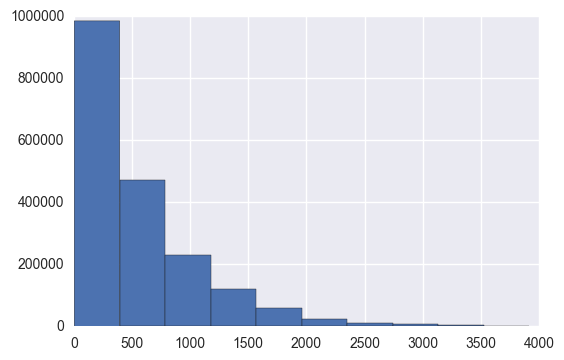

In [122]:
plt.hist([d for dist in full_dists for d in dist])

In [123]:
extractor = Extractor(tagger.copy(), 
                      mention_vocab.v, relation_vocab.v,
                      in_tags=in_tags, out_tags=out_tags,
                      max_rel_dist=200)

In [124]:
best_valid_loss = 1e50
n_valid_up = 0
epoch_losses = [[]]
valid_losses = []
forward_times = [[]]
backward_times = [[]]
seq_lengths = [[]]
fit_start = time.time()
batch_size=64
npr.seed(0)
train_iter = SequenceIterator(zip(ix_train, ib_train, im_train, ir_train), batch_size, repeat=False)
print train_iter.n_batches
for i, batch in enumerate(train_iter):
#     if i >= 50:
#         break
    # prepare data and model
    x_list, b_list, m_list, r_list = zip(*batch)
    x_list = sequences2arrays(x_list)
    b_list = sequences2arrays(b_list)
#     m_list = sequences2arrays(m_list)
#     r_list = sequences2arrays(r_list)
    extractor.reset_state()

    # run model
    start = time.time()
    mention_logits, rel_logits, rel_idxs, dists = extractor(x_list)
    t = float(time.time()-start)/batch_size
#     full_times.append(t)
#     full_dists.extend([abs(r[1]-r[0]) for rels in rel_idxs for r in rels])
    cut_times.append(t)
    cut_dists.extend(dists)
    print t, 'sec/doc'
    print i, '----------------------------------------'
    print [m.shape for m in mention_logits]
    print [r.shape for r in rel_logits]
    print [len(r) for r in rel_idxs]

7
0.324188314378 sec/doc
0 ----------------------------------------
[(142, 23), (181, 23), (204, 23), (198, 23), (205, 23), (167, 23), (195, 23), (151, 23), (168, 23), (109, 23), (143, 23), (136, 23), (140, 23), (118, 23), (112, 23), (119, 23), (101, 23), (90, 23), (96, 23), (120, 23), (98, 23), (78, 23), (60, 23), (59, 23), (44, 23), (52, 23), (40, 23), (55, 23), (76, 23), (52, 23), (60, 23), (40, 23), (60, 23), (40, 23), (56, 23), (38, 23), (56, 23), (40, 23), (37, 23), (42, 23), (33, 23), (19, 23), (26, 23), (31, 23), (39, 23), (33, 23), (41, 23), (31, 23), (37, 23), (36, 23), (33, 23), (29, 23), (17, 23), (18, 23), (19, 23), (15, 23), (9, 23), (16, 23), (16, 23), (18, 23), (14, 23), (15, 23), (16, 23), (10, 23)]
[(1877, 71), (2937, 71), (3700, 71), (3859, 71), (4507, 71), (3052, 71), (4273, 71), (2608, 71), (3903, 71), (1570, 71), (3147, 71), (3121, 71), (3384, 71), (2560, 71), (2456, 71), (3206, 71), (2155, 71), (1806, 71), (1965, 71), (3367, 71), (2580, 71), (1560, 71), (1069, 71

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()

In [127]:
fd = [ d for dists in full_dists for d in dists ]
fn = [ len(dists) for dists in full_dists]

cd = [ d for dists in cut_dists for d in dists ]
cn = [ len(dists) for dists in cut_dists]

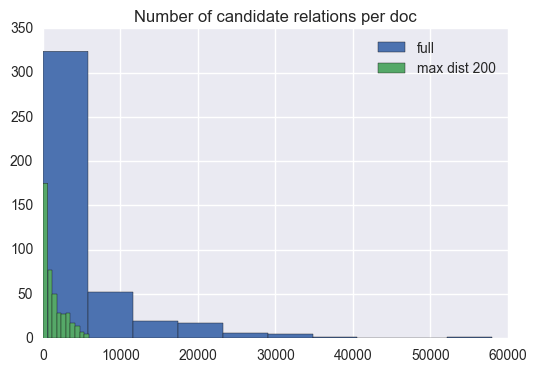

In [137]:
plt.hist(fn, label='full')
plt.hist(cn, label='max dist 200')
plt.legend()
plt.title('Number of candidate relations per doc')
print 

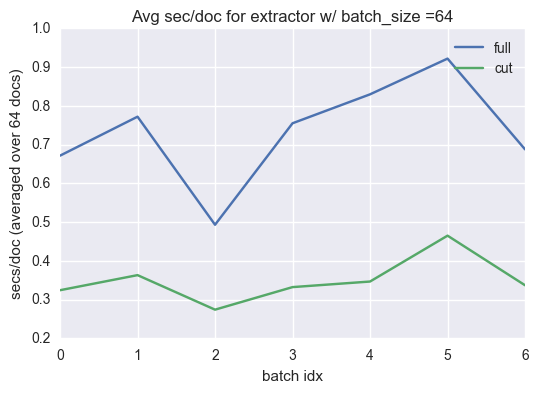

In [139]:
plt.plot(full_times, label='full')
plt.plot(cut_times, label='cut')
plt.legend()
plt.title('Avg sec/doc for extractor w/ batch_size =64')
plt.xlabel('batch idx')
plt.ylabel('secs/doc (averaged over 64 docs)')
print

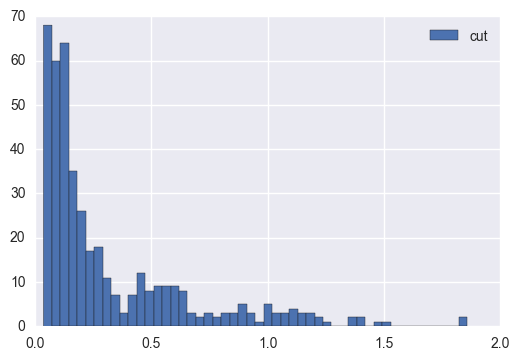

In [91]:
plt.hist(cut_times, label='cut', bins=50)
plt.legend()
print 

(array([ 0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.]),
 array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5]),
 <a list of 10 Patch objects>)

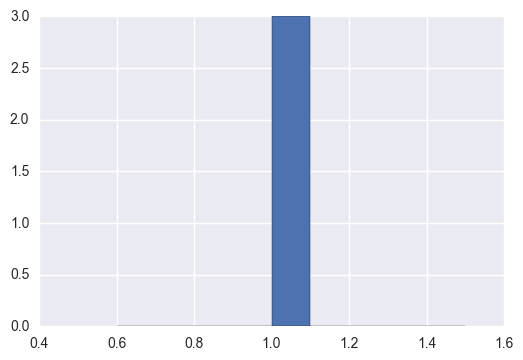

In [81]:
plt.hist([1,1,1])

In [92]:
np.array([[1,0],[1,1]]).size

4

In [203]:
a = ch.Variable(np.array([[1.0, 0.], [0., 1.], [2., 3.]]))
b = np.array([0., 1., .1]).reshape((-1,1))
a *= b
print a.data

[[ 0.   0. ]
 [ 0.   1. ]
 [ 0.2  0.3]]
